In [ ]:
!pip install tensorflow_addons

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa


In [ ]:
class Linear(keras.layers.Layer):
    """y = w.x + b"""

    def __init__(self, units):
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [ ]:
class ActivityRegularization(keras.layers.Layer):
    """Layer that creates an activity sparsity regularization loss."""

    def __init__(self, rate=1e-2):
        super(ActivityRegularization, self).__init__()
        self.rate = rate

    def call(self, inputs):
        # We use `add_loss` to create a regularization loss
        # that depends on the inputs.
        self.add_loss(self.rate * tf.reduce_sum(inputs))
        return inputs

In [ ]:
class SparseMLP(keras.layers.Layer):
    """Stack of Linear layers with a sparsity regularization loss."""

    def __init__(self):
        super(SparseMLP, self).__init__()
        self.linear_1 = Linear(128)
        #self.regularization = ActivityRegularization(1e-2)
        self.linear_2 = Linear(32)
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.linear_3 = Linear(10)


    def call(self, inputs):
        x = self.linear_1(inputs)
        x = tfa.activations.softshrink(x, lower = -0.05,upper = 0.05)
        #x = self.regularization(x)
        x = self.linear_2(x)
        x = tfa.activations.softshrink(x, lower=-.05, upper=0.05)
        x = self.dropout(x)
        x= self.linear_3(x)
        return tfa.activations.softshrink(x, lower=-.05, upper = 0.05)



In [ ]:
def exponential_loss(y_true,y_pred):
  y_true = tf.one_hot(y_true,off_value=-1.,depth=10)
  loss = tf.reduce_sum(tf.math.exp(-tf.multiply(y_true,y_pred)))
  return loss/len(y_true)

In [ ]:
(x_train, y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data()
dataset = tf.data.Dataset.from_tensor_slices(
    (x_train.reshape(60000, 784).astype("float32") / 255, y_train)
)
dataset = dataset.shuffle(buffer_size=512).batch(64)

# A new MLP.
mlp = SparseMLP()

# Loss and optimizer.
#loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn = exponential_loss
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
losses=[]

for step, (x, y) in enumerate(dataset):
    with tf.GradientTape() as tape:

        # Forward pass.
        logits = mlp(x)

        # External loss value for this batch.
        loss = loss_fn(y, logits)

        # Add the losses created during the forward pass.
        loss += sum(mlp.losses)
        
        # Get gradients of weights wrt the loss.
        gradients = tape.gradient(loss, mlp.trainable_weights)
        #print(gradients)
    # Update the weights of our linear layer.
    optimizer.apply_gradients(zip(gradients, mlp.trainable_weights))

    losses.append(float(loss))

    # Logging.
    if step % 100 == 0:
        print("Step:", step, "Loss:", float(loss))

Step: 0 Loss: 10.093910217285156
Step: 100 Loss: 9.335864067077637
Step: 200 Loss: 6.6553473472595215
Step: 300 Loss: 6.163985252380371
Step: 400 Loss: 6.138213157653809
Step: 500 Loss: 6.205282211303711
Step: 600 Loss: 5.82169246673584
Step: 700 Loss: 5.9918084144592285
Step: 800 Loss: 5.641983509063721
Step: 900 Loss: 5.585603713989258


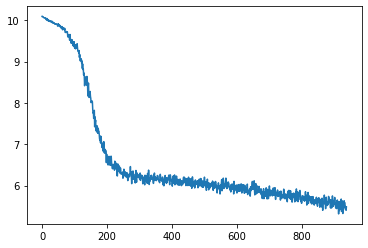

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(losses)


In [ ]:
!pip install tensorflow_addons